# Taiwan Credit Risk: XGBoost for Feature Selection

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/Github/ml-blog

/content/gdrive/MyDrive/Github/ml-blog


In [ ]:
!pip install xlrd==1.2.0
!pip install matplotlib==3.5.3

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xlrd


filename = 'default of credit card clients.xls'

DATA = os.path.relpath('/content/gdrive/MyDrive/Github/ml-blog/credit/data/' + filename)

df = pd.read_excel(DATA, 'Data', index_col=[0], header=[1], na_values='NA')
df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


* First, we separate the categorical data columns from the continuous numeric ones.

In [5]:
X = df.copy()
cat_features = X.iloc[:, 1:11]
num_features = X.iloc[:, 11:23]
y = X.iloc[:, 23]
cat_features.info(), num_features.info(), y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   SEX        30000 non-null  int64
 1   EDUCATION  30000 non-null  int64
 2   MARRIAGE   30000 non-null  int64
 3   AGE        30000 non-null  int64
 4   PAY_0      30000 non-null  int64
 5   PAY_2      30000 non-null  int64
 6   PAY_3      30000 non-null  int64
 7   PAY_4      30000 non-null  int64
 8   PAY_5      30000 non-null  int64
 9   PAY_6      30000 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   BILL_AMT1  30000 non-null  int64
 1   BILL_AMT2  30000 non-null  int64
 2   BILL_AMT3  30000 non-null  int64
 3   BILL_AMT4  30000 non-null  int64
 4   BILL_AMT5  30000 non-null  int64
 5   BILL_AMT6  30000

(None, None, ID
 1        1
 2        1
 3        0
 4        0
 5        0
         ..
 29996    0
 29997    0
 29998    1
 29999    1
 30000    1
 Name: default payment next month, Length: 30000, dtype: int64)

In [6]:
from sklearn.model_selection import train_test_split

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(cat_features, y, test_size=0.2, random_state=42)
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(num_features, y, test_size=0.2, random_state=42)

In [7]:
from xgboost import XGBClassifier

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01356
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00166
Feature: 4, Score: 0.74232
Feature: 5, Score: 0.14627
Feature: 6, Score: 0.00889
Feature: 7, Score: 0.06305
Feature: 8, Score: 0.00664
Feature: 9, Score: 0.01760


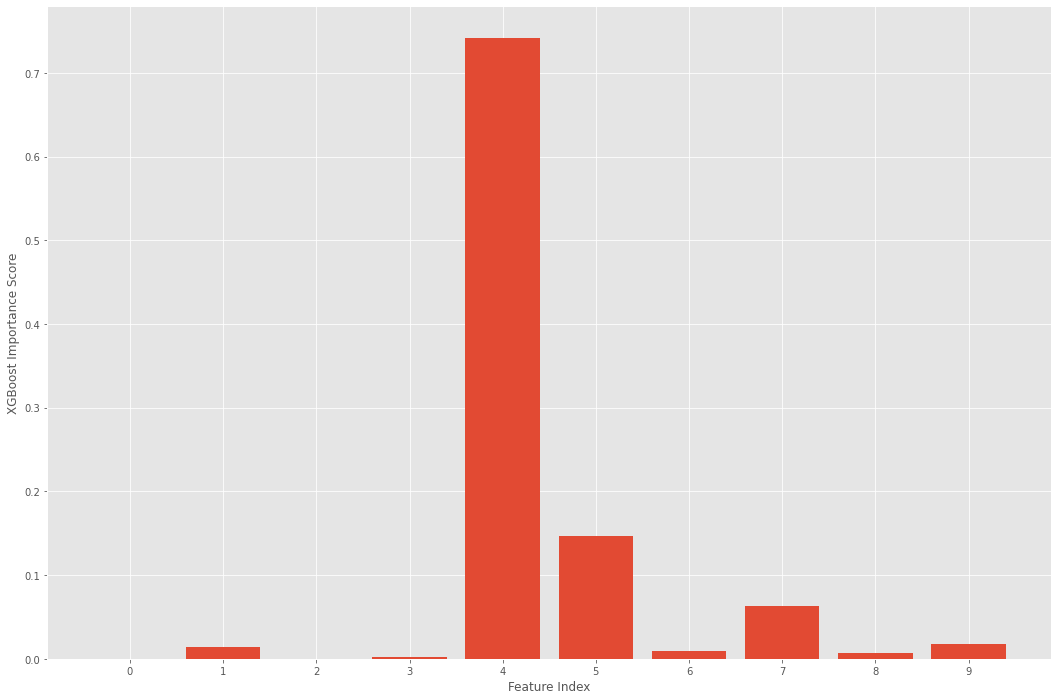

In [214]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.0001)
xgb_model.fit(X_cat_train, y_cat_train)
xgb_import = xgb_model.feature_importances_

for i, v in enumerate(xgb_import):
    print("Feature: %0d, Score: %.5f" % (i, v))

plt.style.use('ggplot')
plt.figure(figsize=(18, 12))
plt.bar([x for x in range(len(xgb_import))], xgb_import)
plt.xticks(range(len(xgb_import)))
plt.xlabel('Feature Index')
plt.ylabel('XGBoost Importance Score')
plt.savefig('xgb_boost_importance.png')
plt.show()

In [215]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [216]:
y_xgb_cat_probas = xgb_model.predict_proba(X_cat_test)[:, 1]
y_xgb_cat_test_np = y_cat_test.to_numpy()

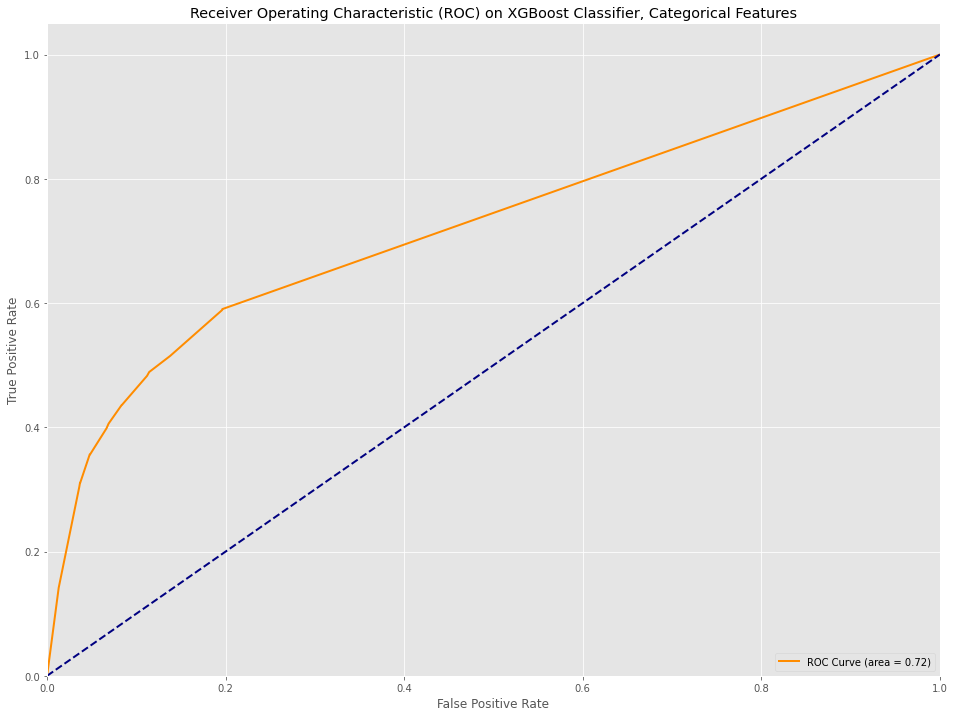

In [217]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_xgb_cat_test_np, y_xgb_cat_probas)
roc_auc = auc(falsePR, truePR)

plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on XGBoost Classifier, Categorical Features')
plt.legend(loc='lower right')
plt.savefig('./credit/EDA/xgboost-features-roc-auc-plot.png')
plt.show()


In [219]:
y_xgb_cat_preds = xgb_model.predict(X_cat_test)

print(confusion_matrix(y_cat_test, y_xgb_cat_preds))
print('Accuracy Score, XGBoost - Categorical Features-only', round(xgb_model.score(X_cat_test, y_cat_test) * 100, 3), '%')

[[4462  225]
 [ 845  468]]
Accuracy Score, XGBoost - Categorical Features-only 82.167 %


## Logistic Regression with One-Hot Categorical Features Only

In [166]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from time import time

feature_names = np.array(X_cat_train.columns)

tic = time()
fselect = SelectFromModel(LogisticRegression(penalty='l1', C=1.5, tol=0.001, solver='saga', max_iter=300), threshold=0.08).fit(X_cat_train, y_cat_train)
toc = time()

print(f"Features selected for Logistic Regression with SelectFromModel: {feature_names[fselect.get_support()]}")
print(f"Done in {toc - tic:.3f}s")
# fselector.fit(X_cat_train, y_cat_train)
X_cat_train_fs_logreg = fselect.transform(X_cat_train)
X_cat_test_fs_logreg = fselect.transform(X_cat_test)


Features selected for Logistic Regression with SelectFromModel: ['SEX' 'MARRIAGE' 'PAY_0' 'PAY_2' 'PAY_3']
Done in 0.716s


In [167]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

lr_pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('lr', LogisticRegression(penalty='l1', C=1.5, tol=0.001, solver='saga', max_iter=300))

])

lr_pipe.fit(X_cat_train_fs_logreg, y_cat_train)

Pipeline(steps=[('ohe', OneHotEncoder()),
                ('lr',
                 LogisticRegression(C=1.5, max_iter=300, penalty='l1',
                                    solver='saga', tol=0.001))])

In [168]:
y_cat_probas = lr_pipe.predict_proba(X_cat_test_fs_logreg)[:, 1]
y_cat_test_np = y_cat_test.to_numpy()

In [169]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

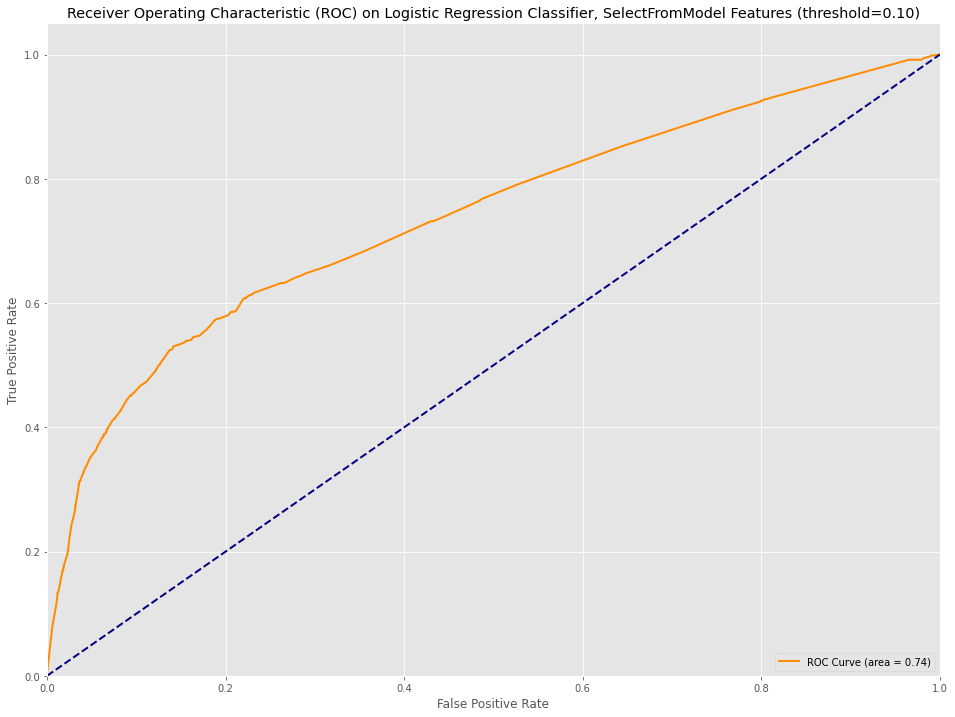

In [170]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_cat_test_np, y_cat_probas)
roc_auc = auc(falsePR, truePR)

plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on Logistic Regression Classifier, SelectFromModel Features (threshold=0.10)')
plt.legend(loc='lower right')
plt.savefig('./credit/EDA/logreg-3features-roc-auc-plot.png')
plt.show()


In [171]:
from sklearn.metrics import classification_report, confusion_matrix

y_cat_preds = lr_pipe.predict(X_cat_test_fs_logreg)
print(classification_report(y_cat_test, y_cat_preds))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4687
           1       0.68      0.34      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



In [172]:
print(confusion_matrix(y_cat_test, y_cat_preds))

[[4483  204]
 [ 872  441]]


In [173]:
print('Accuracy Score, Categorical Features-only', round(lr_pipe.score(X_cat_test_fs_logreg, y_cat_test) * 100, 3), '%')

Accuracy Score, Categorical Features-only 82.067 %


## Logistic Regression with Numeric (Continuous) Features Only

In [129]:
num_feature_names = np.array(X_num_train.columns)

tic = time()
fselect_num = SelectFromModel(LogisticRegression(penalty='l1', solver='saga', C=2.0, max_iter=300, multi_class='ovr')).fit(X_num_train, y_num_train)
toc = time()

print(f"Features selected for Logistic Regression with SelectFromModel, Numeric Features: {num_feature_names[fselect_num.get_support()]}")
print(f"Done in {toc - tic:.3f}s")
# fselector.fit(X_cat_train, y_cat_train)
X_num_train_fs_logreg = fselect_num.transform(X_num_train)
X_num_test_fs_logreg = fselect_num.transform(X_num_test)


Features selected for Logistic Regression with SelectFromModel, Numeric Features: ['BILL_AMT1' 'BILL_AMT2' 'PAY_AMT1' 'PAY_AMT2' 'PAY_AMT3' 'PAY_AMT4'
 'PAY_AMT5' 'PAY_AMT6']
Done in 2.423s


In [130]:
from sklearn.preprocessing import MinMaxScaler

lr_num_pipe = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0,1))),
    ('lr_num', LogisticRegression(penalty='l1', solver='saga', C=2.0, max_iter=300, multi_class='ovr'))

])

lr_num_pipe.fit(X_num_train_fs_logreg, y_num_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lr_num',
                 LogisticRegression(C=2.0, max_iter=300, multi_class='ovr',
                                    penalty='l1', solver='saga'))])

In [131]:
y_num_probas = lr_num_pipe.predict_proba(X_num_test_fs_logreg)[:, 1]
y_num_test_np = y_num_test.to_numpy()

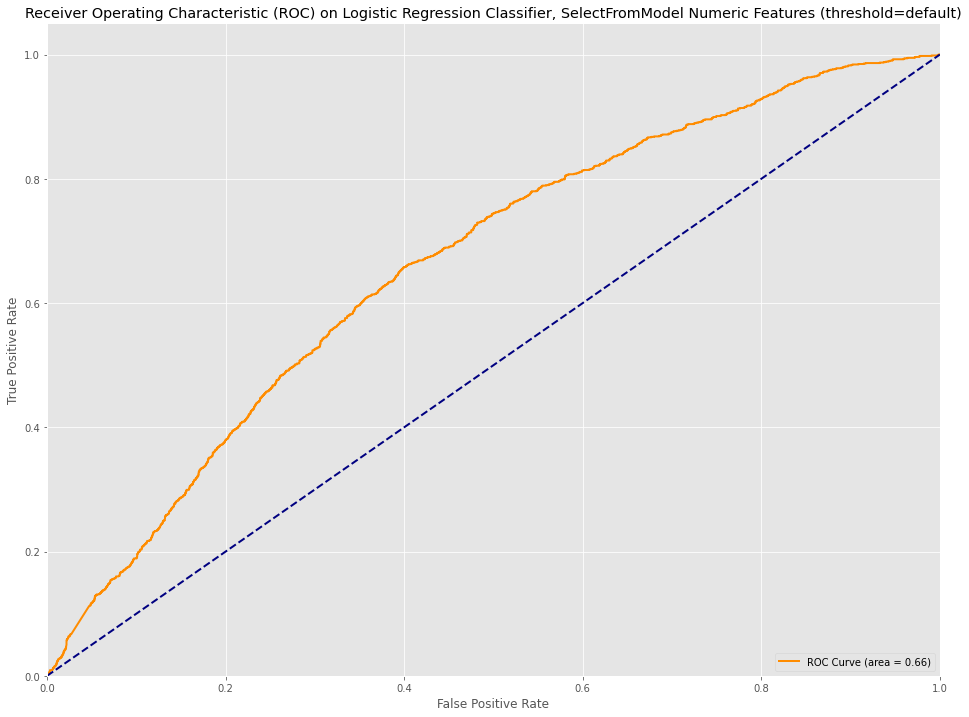

In [132]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_num_test_np, y_num_probas)
roc_auc = auc(falsePR, truePR)

plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on Logistic Regression Classifier, SelectFromModel Numeric Features (threshold=default)')
plt.legend(loc='lower right')
plt.savefig('./credit/EDA/logreg-4numfeatures-roc-auc-plot.png')
plt.show()


In [137]:
y_num_preds = lr_num_pipe.predict(X_num_test_fs_logreg)
print(classification_report(y_num_test, y_num_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4687
           1       1.00      0.00      0.00      1313

    accuracy                           0.78      6000
   macro avg       0.89      0.50      0.44      6000
weighted avg       0.83      0.78      0.69      6000



In [138]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_num_test, y_num_preds))

[[4687    0]
 [1312    1]]


In [81]:
print('Accuracy Score, Numeric Features-only', round(lr_num_pipe.score(X_num_test_fs_logreg, y_num_test) * 100, 3), '%')

Accuracy Score, Numeric Features-only 78.117 %
